# FEATURE ENGINEERING 
### CORREALTION

In [181]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.5f}'.format

# 0. Load Data
* https://www.reneshbedre.com/blog/anova.html

In [182]:
t = time.time()
timeSeries      = False
peakstroughs    = False
samp_to_extract = 0
df_patients, df_admissions, df_eobs = load_fn.Load_data()
X_data       = load_fn.Exctract_Xdata(df_patients, df_admissions, df_eobs, samp_to_extract, peakstroughs, timeSeries  )
X_data['sex'] = X_data['sex'].apply(lambda x: 0 if x ==-1 else x)
print("Elapsed time:", time.time()-t)

Elapsed time: 88.74057006835938


In [183]:
X_data.head(4)

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Confusion,UREA,CREA,K,GFR,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,74554266,18,0,78.00000,36.10000,120.00000,67.00000,98.00000,0,6.07000,75.40000,3.76000,90.00150,0,0,72,0,0,0.00000,0
144,30248532,16,0,68.00000,36.50000,157.00000,88.00000,96.00000,0,8.20000,76.00000,4.40000,67.00000,1,1,86,1,1,1.00000,0
288,81444331,18,0,54.00000,36.70000,135.00000,68.00000,96.00000,0,12.88571,165.28571,4.38571,27.28571,1,1,86,4,0,1.00000,1
432,6483250,22,8,100.50000,36.70000,88.00000,59.50000,95.50000,0,8.30000,162.00000,4.50000,37.00000,0,0,89,9,1,1.00000,0


In [184]:
feat_list = X_data.columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Confusion', 'UREA', 'CREA', 'K', 'GFR', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 18


# 1. Feature correlation

* Two continuos variables spearman coefficient [-1,1]
* Two Categorical variables Cramer'sV coeeficient [0,1]
* A categorical variable witha  contionuous variables Point biseral correlation [-1,1]

In [185]:
# Loading the CSV with types
data_types = pd.read_csv('csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

In [186]:
from scipy import stats
def correlation_dependednt_type(X_data, feat1, type1, feat2, type2):
    serie1 = X_data[feat1].tolist()
    serie2 = X_data[feat2].tolist()
    # Spearman correlation for two continuous variables
    if (type1 == 'Continuous') and (type2 == 'Continuous'):
        coef, p = stats.spearmanr(serie1, serie2)
    # Cramer'sV correlation for two categorical variables
    elif (type1 == 'Categorical') and (type2 == 'Categorical'):
        #data = np.array([serie1, serie2])
        df   = pd.DataFrame(zip(serie1, serie2))
        data = np.array(pd.crosstab(df[0],df[1]))
        #Chi-squared test statistic, sample size, and minimum of rows and columns
        X2, p,_,_ = stats.chi2_contingency(data, correction=False)
        n = np.sum(data)
        minDim = min(data.shape)-1
        #calculate Cramer's V 
        coef = np.sqrt((X2/n) / minDim)
    else: # When types are different, Point biserial Correlation
        coef, p = stats.pointbiserialr(np.array(serie1), np.array(serie2))
    return coef, p

In [187]:
corr = pd.DataFrame(np.zeros((len(feat_list),len(feat_list))), columns = feat_list, index= feat_list)
for idx, feat1 in enumerate(feat_list):
    for feat2 in feat_list[idx:]:
        type1   = data_types[feat1]
        type2   = data_types[feat2]
        if feat1 == feat2:
            corr_ = 1
            p = 0
        else:    
            corr_, p = correlation_dependednt_type(X_data, feat1, type1, feat2, type2)
        corr.at[feat1, feat2] = corr_
        corr.at[feat2, feat1] = corr_
        print(feat1, feat2, p)


rr rr 0
rr ews 0.0
rr heart_rate 6.821378471129129e-238
rr temperature 4.803060779887377e-89
rr sbp 0.790114735337505
rr dbp 0.005183398303330104
rr Oxygen_Saturation 4.375906414041743e-111
rr Confusion 9.897809476045171e-11
rr UREA 1.4279502894787441e-07
rr CREA 0.003313767606062122
rr K 1.831056723022534e-08
rr GFR 1.403745218750923e-06
rr sex 0.16420499886551695
rr ethnicity 0.41366137089721
rr age_at_admin 2.3012789629116578e-10
rr Comorb_score 0.1207014016820128
rr Spcfc_Comorb 7.63586382528866e-41
rr had_Prev_admin 0.0002939114497557646
ews ews 0
ews heart_rate 0.0
ews temperature 7.43411845117554e-99
ews sbp 1.1393578780509933e-123
ews dbp 3.7081062939279385e-12
ews Oxygen_Saturation 0.0
ews Confusion 0.0
ews UREA 3.5044677374236976e-07
ews CREA 0.5714180231449651
ews K 0.00045128757594313826
ews GFR 5.093886598827504e-08
ews sex 0.0373582911562434
ews ethnicity 0.9881374578959246
ews age_at_admin 0.17178310747765974
ews Comorb_score 0.29652055097547086
ews Spcfc_Comorb 6.023306

# 2. Create a correlation plot

<AxesSubplot:>

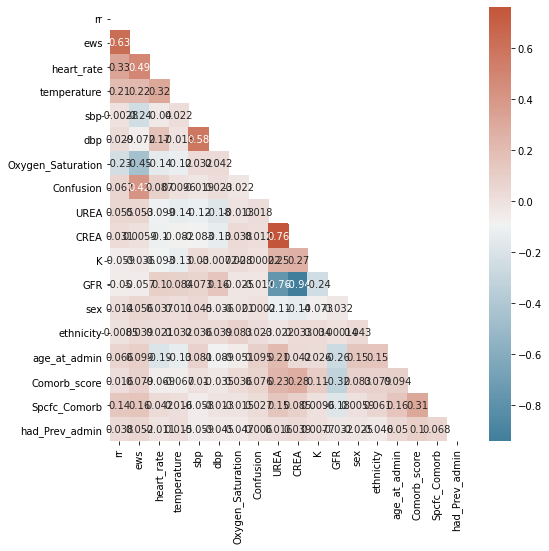

In [188]:
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for upper traingle#
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#ax.set_title('Sector 68 - Picarquin')
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [189]:
##############################################
############### ANOVA ########################
####### Differences Among Groups #############
# Whether ONE variable mean differs from different groups. Groups
# are the combination of the levels in each factor. ANOVA assess the impact 
# per group and not the impact of each variable. 
##############################################
#https://www.reneshbedre.com/blog/anova.html
import statsmodels.api as sm
from statsmodels.formula.api import ols
t = time.time()
model = ols('Mortality ~ C(rr) + C(ews) + C(heart_rate) + C(temperature)\
            + C(sbp) + C(dbp) + C(Oxygen_Saturation) + C(Confusion) + C(UREA) + C(CREA) + \
            C(K) + C(GFR) + C(sex) + C(ethnicity) + C(age_at_admin) + C(Comorb_score) + \
            C(Spcfc_Comorb)', data=X_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("elapsed time:", time.time()- t)
anova_table

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 269, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The nu

elapsed time: 408.10365653038025


,sum_sq,df,F,PR(>F)
C(rr),6.76943,47.00000,1.05265,0.30503
C(ews),2.44852,17.00000,1.05265,0.30503
C(heart_rate),38.74421,269.00000,1.05265,0.30503
C(temperature),26.50162,184.00000,1.05265,0.30503
C(sbp),41.04870,285.00000,1.05265,0.30503
C(dbp),33.27105,231.00000,1.05265,0.30503
C(Oxygen_Saturation),10.37020,72.00000,1.05265,0.30503
C(Confusion),0.00153,1.00000,0.01116,0.91588
C(UREA),545.83395,"3,795.00000",1.05118,0.30537
C(CREA),501.82501,"3,476.00000",1.05512,0.30447
